In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df=pd.read_csv(r'G:\My Drive\My Data sets for modeling\USA_COVID-19_Total_deaths.csv')
df.head()

,date,cases,deaths
0,02/29/2020,70,1
1,03/01/2020,88,2
2,03/02/2020,104,3
3,03/03/2020,125,4
4,03/04/2020,161,2


In [3]:
df.shape

(277, 3)

In [4]:
df.drop(['cases'],axis=1,inplace=True)

In [5]:
df.isnull().sum()

date      0
deaths    0
dtype: int64

In [6]:
df_tx=df.rename({'deaths':'Death_count'},axis=1)

df_tx['date']=pd.to_datetime(df_tx['date'])

df_tx.set_index('date',inplace=True)

df_tx.head()

,Death_count
date,
2020-02-29,1
2020-03-01,2
2020-03-02,3
2020-03-03,4
2020-03-04,2


In [7]:
df_tx.describe()

,Death_count
count,277.000000
mean,977.003610
std,616.018595
min,0.000000
25%,530.000000
50%,932.000000
75%,1281.000000
max,2752.000000


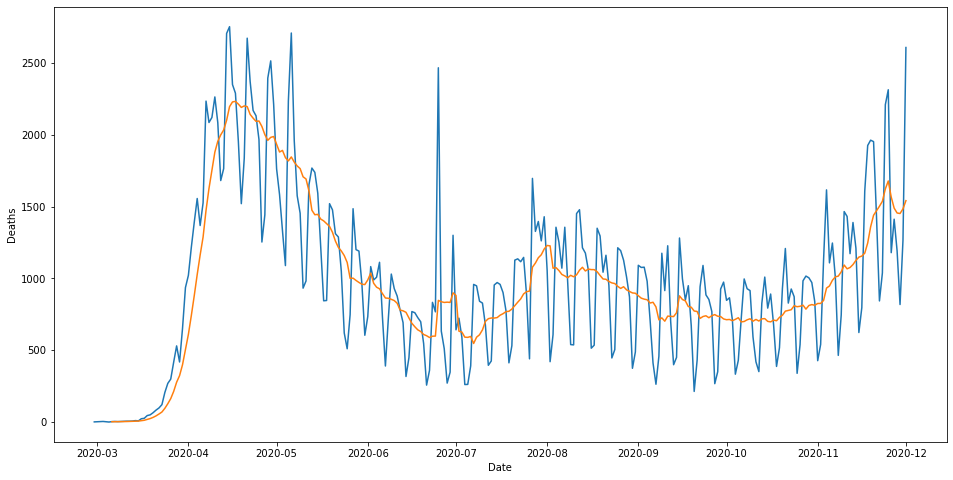

In [137]:
plt.figure(figsize=(16,8))

plt.plot(df_tx.Death_count)

plt.plot(df_tx.Death_count.rolling(7).mean())

plt.xlabel('Date')

plt.ylabel('Deaths')

plt.show()

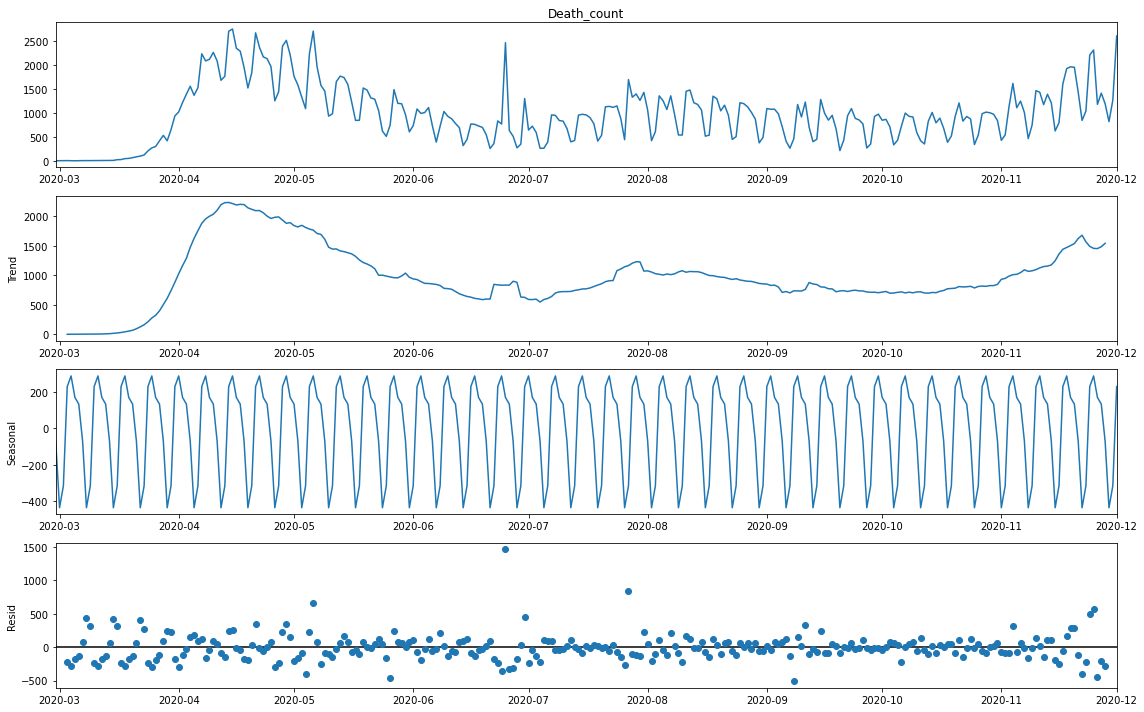

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams

rcParams['figure.figsize']=16,10

result=seasonal_decompose(df_tx.Death_count.dropna(),model='additive')

result.plot()

plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

ADF_test=adfuller(df_tx.Death_count.dropna())

print ('ADF statistics: %f' %ADF_test[0])

print ('p-value: %f' %ADF_test[1])

print ('Critical values:')

for key,value in ADF_test[4].items():
    
    print('\t%s: %.4f'%(key,value))

ADF statistics: -2.997795
p-value: 0.035101
Critical values:
	1%: -3.4557
	5%: -2.8727
	10%: -2.5727


In [11]:
from statsmodels.tsa.stattools import kpss

kpss_test=kpss(df_tx.Death_count.dropna(),regression='c')

print ('ADF statistics: %f' %kpss_test[0])

print ('p-value: %f' %kpss_test[1])

print ('Critical values:')

for key,value in kpss_test[3].items():
    
    print('\t%s: %.4f'%(key,value))

ADF statistics: 0.099708
p-value: 0.100000
Critical values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390


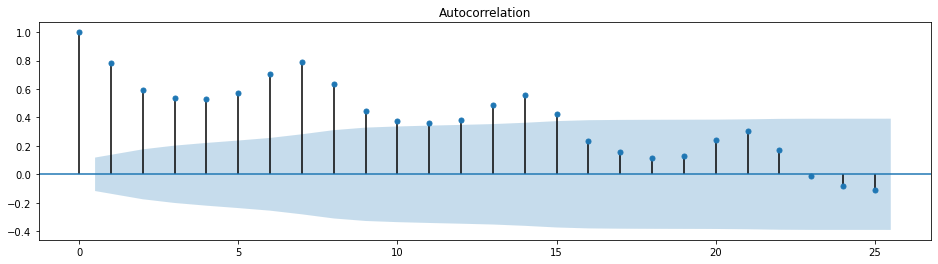

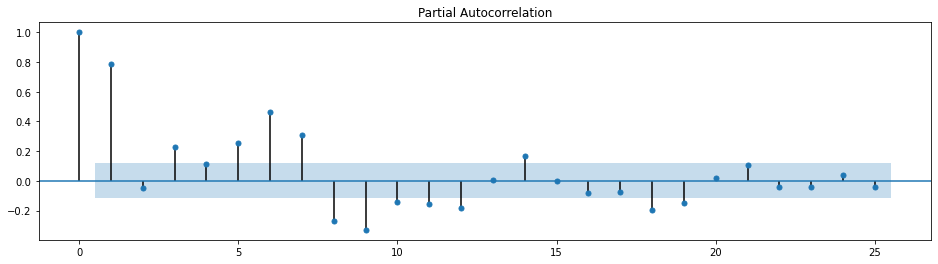

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

rcParams['figure.figsize']=16,4

plot_acf(df_tx.Death_count)

plot_pacf(df_tx.Death_count)

plt.show()

In [13]:
df_tx['first difference']=df_tx['Death_count']-df_tx['Death_count'].shift(1)

In [14]:
ADF_test=adfuller(df_tx['first difference'].dropna())

print ('ADF statistics: %f' %ADF_test[0])

print ('p-value: %f' %ADF_test[1])

print ('Critical values:')

for key,value in ADF_test[4].items():
    
    print('\t%s: %.4f'%(key,value))

ADF statistics: -2.634406
p-value: 0.086093
Critical values:
	1%: -3.4559
	5%: -2.8728
	10%: -2.5728


In [15]:
df_tx['seasonal first difference']=df_tx['first difference']-df_tx['first difference'].shift(7)

In [16]:
ADF_test=adfuller(df_tx['seasonal first difference'].dropna())

print ('ADF statistics: %f' %ADF_test[0])

print ('p-value:  %.9f' %ADF_test[1])

print ('Critical values:')

for key,value in ADF_test[4].items():
    
    print('\t%s: %.4f'%(key,value))

ADF statistics: -5.972054
p-value:  0.000000193
Critical values:
	1%: -3.4563
	5%: -2.8729
	10%: -2.5728


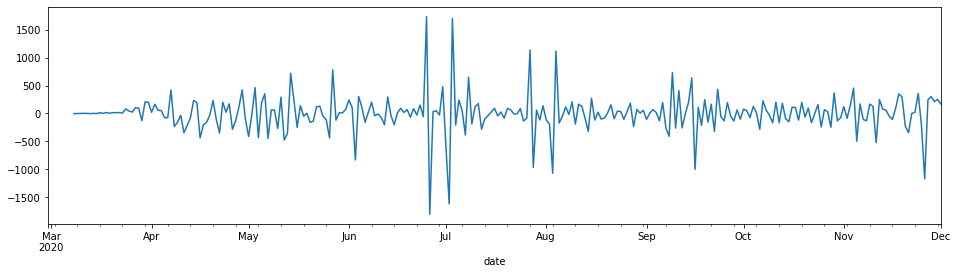

In [140]:
df_tx['seasonal first difference'].plot(figsize=(16,4))

plt.show()

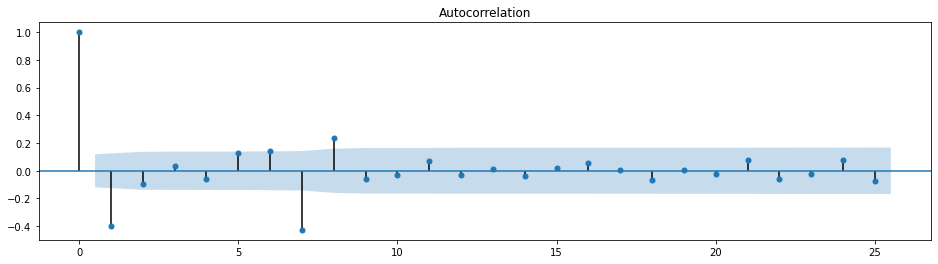

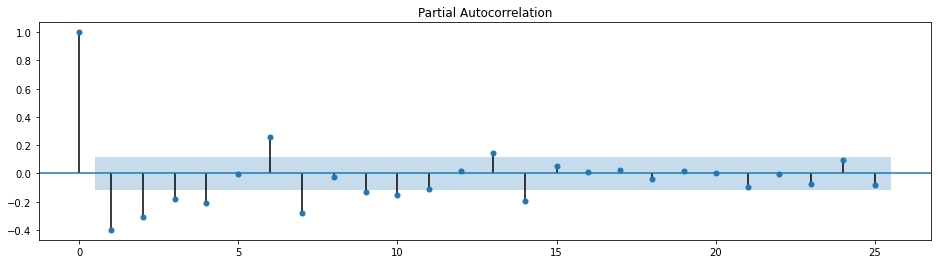

In [18]:
plot_acf(df_tx['seasonal first difference'].dropna())

plt.show()

plot_pacf(df_tx['seasonal first difference'].dropna())

plt.show()

In [19]:
import statsmodels.api as sm

In [70]:
model=sm.tsa.statespace.SARIMAX(df_tx['Death_count'].dropna(),
                                order=(0,1,1),
                                seasonal_order=(1,1,2,7)).fit()

In [71]:
print(model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                            Death_count   No. Observations:                  277
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood               -1868.589
Date:                                Thu, 07 Jan 2021   AIC                           3747.179
Time:                                        11:02:50   BIC                           3765.152
Sample:                                    02-29-2020   HQIC                          3754.397
                                         - 12-01-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6132      0.035    -17.582      0.000      -0.682      -0.545
ar.

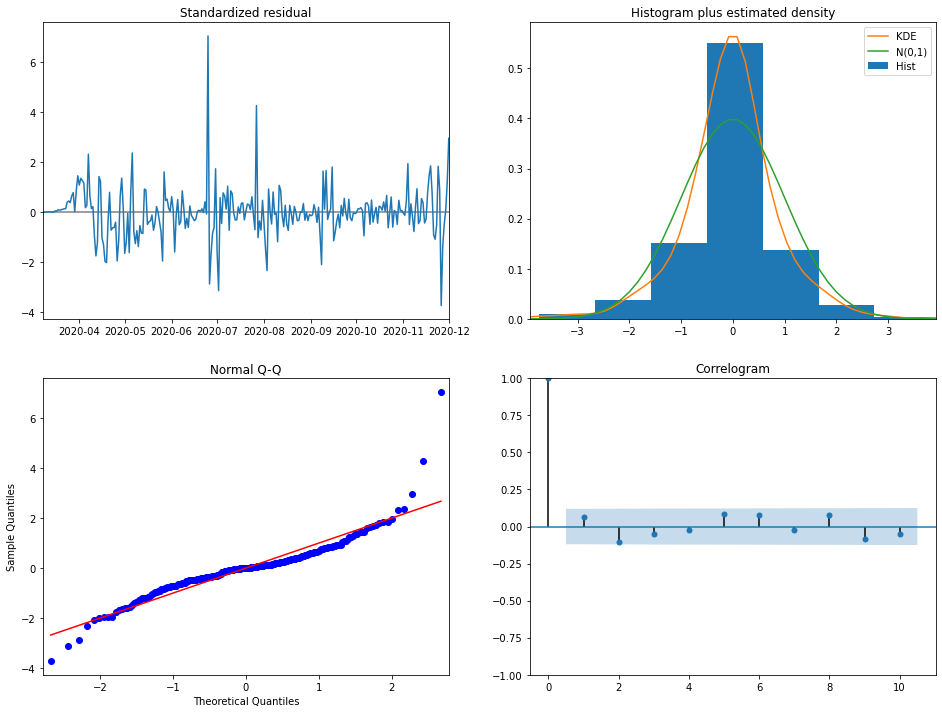

In [149]:
model.plot_diagnostics(figsize=(16,12))

plt.show()

In [87]:
import itertools

In [53]:
p=range(0,3)
d=range(0,2)
q=range(0,3)
pdq=list(itertools.product(p,d,q))

seasonal_pdq=list((x[0],x[1],x[2],7) for x in pdq)

for param in pdq:
    
    for seasonal_param in seasonal_pdq:
        
        try:
            model=sm.tsa.statespace.SARIMAX(df_tx['Death_count'],
                                            order=param,
                                            seasonal_order=seasonal_param)
            result=model.fit()
            print('SARIMA{}x{}7 - AIC:{}'.format(param,seasonal_param, result.aic))
        
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:4694.533268596117
SARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:4428.587146937766
SARIMA(0, 0, 0)x(0, 0, 2, 7)7 - AIC:4277.2344512774525
SARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:3929.6224688665407
SARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:3929.803541808977
SARIMA(0, 0, 0)x(0, 1, 2, 7)7 - AIC:3926.8193155709782
SARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:4044.1787996685725
SARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:4043.324824892188
SARIMA(0, 0, 0)x(1, 0, 2, 7)7 - AIC:4038.9995101237946
SARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:3929.334295260975
SARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:3929.678670425995
SARIMA(0, 0, 0)x(1, 1, 2, 7)7 - AIC:3928.353201592472
SARIMA(0, 0, 0)x(2, 0, 0, 7)7 - AIC:4042.405935483874
SARIMA(0, 0, 0)x(2, 0, 1, 7)7 - AIC:4041.2607285179856
SARIMA(0, 0, 0)x(2, 0, 2, 7)7 - AIC:4039.338495725916
SARIMA(0, 0, 0)x(2, 1, 0, 7)7 - AIC:3926.995248086476
SARIMA(0, 0, 0)x(2, 1, 1, 7)7 - AIC:3928.98212671322
SARIMA(0, 0, 0)x(2, 1, 2, 7)7 - AIC:3924.2122066995908
SARIMA(0, 0, 1)x(0, 0,

In [120]:
y=df_tx['Death_count']
y_train = y[:'2020-10-01'] 
y_test = y['2020-10-02':] 

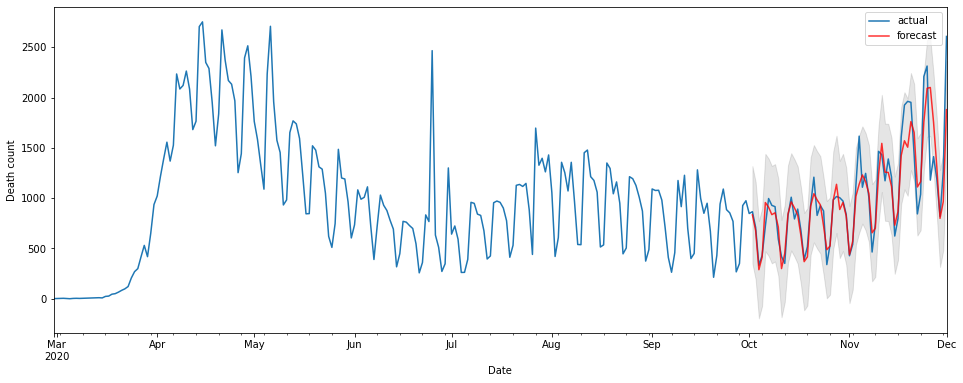

In [150]:
predict = model.get_prediction(start='2020-10-02', dynamic=False)

predict_ci = predict.conf_int()

y_forecast = predict.predicted_mean

ax = y.plot(label='actual',figsize=(16,6))

y_forecast.plot(ax=ax, label='forecast', alpha=.8,color='r')

ax.fill_between(predict_ci.index,predict_ci.iloc[:, 0],
                predict_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')

ax.set_ylabel('Death count')

plt.legend()

plt.show()